Text

In [77]:
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
import seaborn as sns
import datetime as dt
from datetime import datetime
from datetime import timezone
import pandas_profiling
import pyodbc
import warnings
%matplotlib inline

# Get power consumption data from database

In [78]:
# Get data electric consumption for Gemeente=Alken AND Register=Afname

# Connect to database 'SmartMeterData'
connStr = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER=P210180\SYNTRA_TNVN;DATABASE=SmartMeterData;Trusted_Connection=yes')
cursor = connStr.cursor()

# Query data electric consumption for Gemeente=Alken AND Register=Afname
query_elek_Alken_Afname = '''SELECT VanDatum,VanTijdstip,Register,Volume,Gemeente FROM Elektriciteit
            INNER JOIN EANcodes ON Elektriciteit.EAN = EANcodes.[EAN-code]
            WHERE Gemeente = 'Alken'
            AND Register = 'Afname' '''
df_elek_Afname = pd.read_sql(query_elek_Alken_Afname, connStr)

# Ignore warnings
warnings.filterwarnings('ignore')

# Set datetime as index
df_elek_Afname['Datetime'] = pd.to_datetime(df_elek_Afname['VanDatum'] + " " + df_elek_Afname['VanTijdstip'], dayfirst=True)
df_elek_Afname.set_index('Datetime',inplace=True,drop=True)

# Convert dtype of volume to float 
df_elek_Afname['Afname (kWh)'] = df_elek_Afname['Volume'].str.replace(',', '.').astype(float)

#Remove unnecessary colums
del df_elek_Afname['VanDatum']
del df_elek_Afname['VanTijdstip']
del df_elek_Afname['Register']
del df_elek_Afname['Volume']
del df_elek_Afname['Gemeente']

df_elek_Afname

,Afname (kWh)
Datetime,
2022-01-01 00:00:00,1.187
2022-01-01 00:15:00,0.975
2022-01-01 00:30:00,0.964
2022-01-01 00:45:00,1.355
2022-01-01 01:00:00,1.087
...,...
2022-06-30 22:45:00,0.109
2022-06-30 23:00:00,0.134
2022-06-30 23:15:00,0.120


In [79]:
# Get data electric consumption for Gemeente=Alken AND Register=Injectie

# Query data electric consumption for Gemeente=Alken AND Register=Injectie
query_elek_Alken_Injectie = '''SELECT VanDatum,VanTijdstip,Register,Volume,Gemeente FROM Elektriciteit
            INNER JOIN EANcodes ON Elektriciteit.EAN = EANcodes.[EAN-code]
            WHERE Gemeente = 'Alken'
            AND Register = 'Injectie' '''
df_elek_Injectie = pd.read_sql(query_elek_Alken_Injectie, connStr)

# Ignore warnings
warnings.filterwarnings('ignore')

# Set datetime as index
df_elek_Injectie['Datetime'] = pd.to_datetime(df_elek_Injectie['VanDatum'] + " " + df_elek_Injectie['VanTijdstip'], dayfirst=True)
df_elek_Injectie.set_index('Datetime',inplace=True,drop=True)

# Convert dtype of volume to float 
df_elek_Injectie['Injectie (kWh)'] = df_elek_Injectie['Volume'].str.replace(',', '.').astype(float)

#Remove unnecessary colums
del df_elek_Injectie['VanDatum']
del df_elek_Injectie['VanTijdstip']
del df_elek_Injectie['Register']
del df_elek_Injectie['Volume']
del df_elek_Injectie['Gemeente']

df_elek_Injectie

,Injectie (kWh)
Datetime,
2022-01-01 00:00:00,0.0
2022-01-01 00:15:00,0.0
2022-01-01 00:30:00,0.0
2022-01-01 00:45:00,0.0
2022-01-01 01:00:00,0.0
...,...
2022-06-30 22:45:00,0.0
2022-06-30 23:00:00,0.0
2022-06-30 23:15:00,0.0


# Prepare power consumption data for data analysis

In [80]:
# Merge the 2 dataframes into 1
df_elek = pd.merge(df_elek_Afname,df_elek_Injectie, on='Datetime')
df_elek

,Afname (kWh),Injectie (kWh)
Datetime,,
2022-01-01 00:00:00,1.187,0.0
2022-01-01 00:15:00,0.975,0.0
2022-01-01 00:30:00,0.964,0.0
2022-01-01 00:45:00,1.355,0.0
2022-01-01 01:00:00,1.087,0.0
...,...,...
2022-06-30 22:45:00,0.109,0.0
2022-06-30 23:00:00,0.134,0.0
2022-06-30 23:15:00,0.120,0.0


In [81]:
# Resample the dataframes

# Resample on 15min (original)
df_elek_15min = df_elek

# Resample on 1hour
df_elek_hourly = df_elek.resample(rule='H').sum()

# Resample on daily
df_elek_daily = df_elek.resample(rule='D').sum()

# Data analysis questions

## Show the electric power consumption and injection time profile, on a daily basis

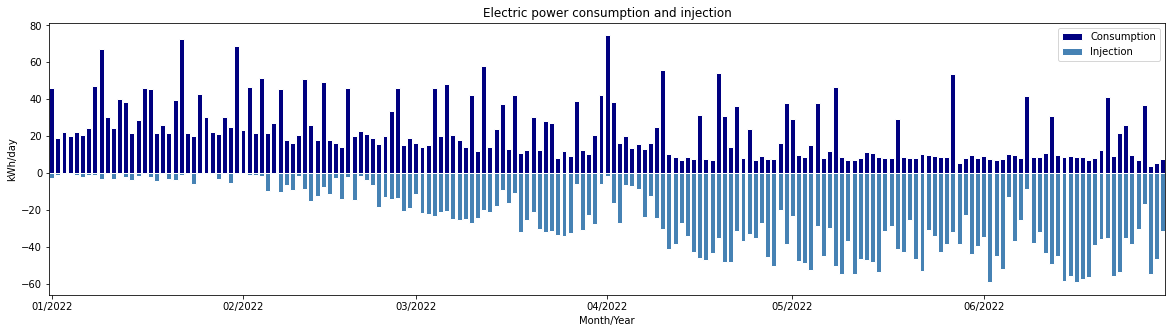

In [82]:
# Define plot space
fig, ax = plt.subplots(figsize = (20,5))

# Create bar plot for electric power consumption
ax.bar(df_elek_daily.index,
       df_elek_daily['Afname (kWh)'],
      color = 'navy',
      edgecolor = 'white',
      label = 'Consumption')

# Create bar plot for electric power injection
ax.bar(df_elek_daily.index,
       -df_elek_daily['Injectie (kWh)'],
      color = 'steelblue',
      edgecolor = 'white',
      label = 'Injection')

# Add title, labels and legend
ax.set(title = "Electric power consumption and injection",
       xlabel = "Month/Year", 
       ylabel = "kWh/day")
ax.legend();

# Customize axes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%Y'))
ax.autoscale(axis='x',tight=True);

plt.show()

## Calculate the total electric power consumption and injection

In [83]:
df_elek_15min.sum()

Afname (kWh)      3987.737
Injectie (kWh)    4435.217
dtype: float64

## Show profile for a specific day

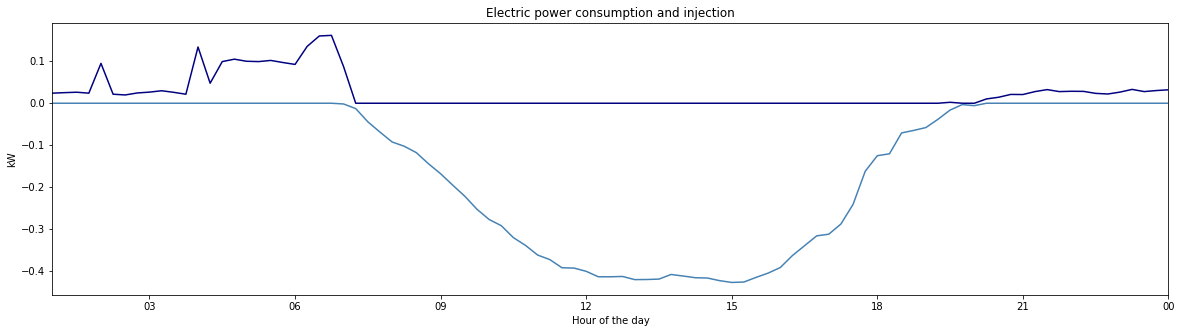

In [84]:
df_elek_15min_selected = df_elek_15min[(df_elek_15min.index<='2022-05-10 00:00:00') & (df_elek_15min.index >= '2022-05-09 01:00:00')]

# Define plot space
fig, ax = plt.subplots(figsize = (20,5))

# Create bar plot for electric power consumption
ax.plot(df_elek_15min_selected['Afname (kWh)']/4,
        color = 'navy')

ax.plot(-df_elek_15min_selected['Injectie (kWh)']/4,
        color = 'steelblue')

# Add title, labels and legend
ax.set(title = "Electric power consumption and injection",
       xlabel = "Hour of the day", 
       ylabel = "kW")

# Customize axes
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
ax.autoscale(axis='x',tight=True);

plt.show()

## Show the load duration curve for the electric power consumption, on 15min basis

In [85]:
df_elek_15min_loadcurve = df_elek_15min['Afname (kWh)'].sort_values(ascending=False)
df_elek_15min_loadcurve = df_elek_15min_loadcurve.reset_index()
df_elek_15min_loadcurve

,Datetime,Afname (kWh)
0,2022-05-27 19:00:00,3.996
1,2022-05-27 19:15:00,3.619
2,2022-03-12 19:45:00,3.590
3,2022-02-18 19:30:00,3.491
4,2022-04-10 19:45:00,3.473
...,...,...
17367,2022-04-05 17:00:00,0.000
17368,2022-04-05 17:15:00,0.000
17369,2022-04-05 17:45:00,0.000
17370,2022-04-05 18:00:00,0.000


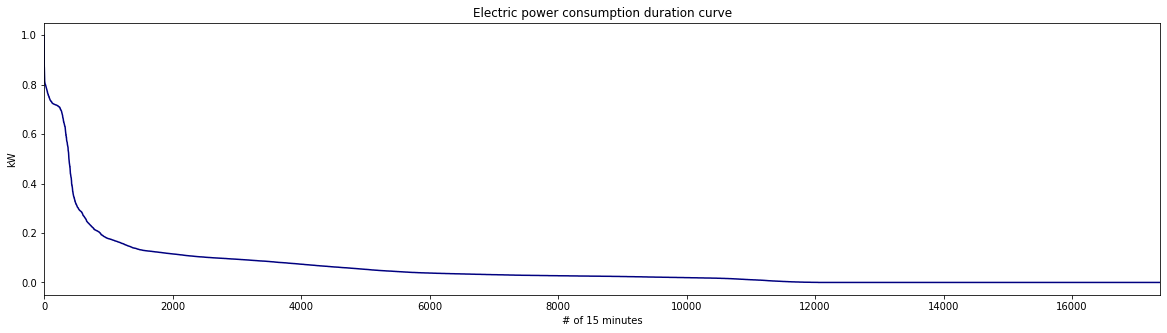

In [86]:
# Define plot space
fig, ax = plt.subplots(figsize = (20,5))

# Create bar plot for electric power consumption
ax.plot(df_elek_15min_loadcurve.index,
        df_elek_15min_loadcurve['Afname (kWh)']/4,
        color = 'navy')

# Add title, labels and legend
ax.set(title = "Electric power consumption duration curve",
       xlabel = "# of 15 minutes", 
       ylabel = "kW")

ax.autoscale(axis='x',tight=True);

plt.show()